In [954]:

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# Data Loading

In [955]:
df = pd.read_csv("./IPL_train.csv")
df.head()

,match_id,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,2,0,0,0,0,0,2,2,NaN,NaN,NaN


# Data cleaning

In [956]:
df.columns

Index(['match_id', 'batting_team', 'bowling_team', 'over', 'ball', 'batsman',
       'non_striker', 'bowler', 'wide_runs', 'bye_runs', 'legbye_runs',
       'noball_runs', 'penalty_runs', 'batsman_runs', 'extra_runs',
       'total_runs', 'player_dismissed', 'dismissal_kind', 'fielder'],
      dtype='object')

In [957]:
df = df.drop(labels=['batsman', 'non_striker', 'bowler', 'wide_runs', 'bye_runs', 'legbye_runs',
       'noball_runs', 'penalty_runs', 'batsman_runs', 'extra_runs', 'player_dismissed', 'fielder'], axis=1)

In [958]:
df.rename(columns={'dismissal_kind':'wickets'}, inplace=True)

In [959]:
df

,match_id,batting_team,bowling_team,over,ball,total_runs,wickets
0,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,0,NaN
1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,0,NaN
2,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,4,NaN
3,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,0,NaN
4,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,2,NaN
...,...,...,...,...,...,...,...
36809,636,Sunrisers Hyderabad,Royal Challengers Bangalore,20,2,6,NaN
36810,636,Sunrisers Hyderabad,Royal Challengers Bangalore,20,3,6,NaN
36811,636,Sunrisers Hyderabad,Royal Challengers Bangalore,20,4,1,NaN
36812,636,Sunrisers Hyderabad,Royal Challengers Bangalore,20,5,1,NaN


In [960]:
def prediction(df:pd.DataFrame, match):
    match_info = df.loc[df['match_id'] == match]
    till_over = np.floor(match_info['over'].iloc[-1])
    if till_over > 12:
        till_over = 8
        match_train = match_info.loc[match_info['over'] < till_over]
    else:
        match_train = match_info

    c = np.array(match_info['total_runs'])
    c_train = np.array(match_train['total_runs'])
    x = np.linspace(0, match_info.shape[0]-1, num=match_info.shape[0])
    x_train = np.linspace(0, match_train.shape[0]-1, num=match_train.shape[0])

    x_pred = []
    for i in range(10):
        x_pred.append(20*6+i)
    fit = np.polyfit(x_train, c_train, 1)
    line = np.poly1d(fit)
    pred_needed = line(x_pred)
    pred = line(x)
    return pred_needed, pred, c, c_train, x, x_train, till_over

In [961]:
def plot_pred(df:pd.DataFrame, match):
    pred_needed, pred, c, c_train, x, x_train, till_over = prediction(df, match)
    # print("Prediction:", pred[-1], ", Actual:", c[-1])
    fig, axis = plt.subplots()
    axis.plot(x, c)
    axis.plot(x_train, c_train)
    axis.plot(x, pred)
    plt.show()

In [962]:
def fix_wicket_column(df:pd.DataFrame):
    df['wickets'] = df['wickets'].fillna(0)
    df.loc[df['wickets']!=0, 'wickets'] = 1
    return df

In [963]:
def merge_over_and_ball_columns(df:pd.DataFrame):
    df['over'] = df['over'] + df['ball']*0.1
    df.drop(labels='ball', axis=1, inplace=True)
    return df

In [964]:
def add_runs_wickets_cumulative_column(df:pd.DataFrame, n:int, matches:np.array):
    assert n<8, "ValueError"
    match_dataframes = []
    for match in matches:
        match_info = df[df['match_id']==match].reset_index()
        runs = 0
        wickets = 0
        runs_past_n = []
        wickets_past_n = []
        runs_his = []
        wickets_his = []
        for idx in range(match_info.shape[0]):
            runs += match_info['total_runs'].iloc[idx]
            match_info['total_runs'].iloc[idx] = runs
            wickets += match_info['wickets'].iloc[idx]
            match_info['wickets'].iloc[idx] = wickets
            runs_past_n.append(match_info['total_runs'].iloc[idx])
            wickets_past_n.append(match_info['wickets'].iloc[idx])
            if len(runs_past_n) > n*6:
                runs_past_n.pop(0)
                wickets_past_n.pop(0)
            runs_his.append(runs_past_n[-1]-runs_past_n[0])
            wickets_his.append(wickets_past_n[-1]-wickets_past_n[0])
        pred_needed, pred, _, _, _, _, till_over = prediction(match_info, match)
        match_info = match_info.assign(runs_past=pd.Series(np.array(runs_his)).values)
        match_info = match_info.assign(wickets_past=pd.Series(np.array(wickets_his)).values)
        match_info = match_info.assign(Total=pd.Series(np.ones(len(runs_his))*runs).values)
        match_info = match_info.assign(run_rate_pred=pd.Series(np.ones(len(runs_his))*pred_needed[0]).values) # pred_needed[0] is prediction at 20*6 balls
        match_dataframes.append(match_info)
    df = pd.concat(match_dataframes).reset_index()
    return df

In [965]:
matches = df['match_id'].unique()
df = fix_wicket_column(df)
df = merge_over_and_ball_columns(df)
df = add_runs_wickets_cumulative_column(df, 4, matches)
# takes ~20 seconds

In [966]:
df

,level_0,index,match_id,batting_team,bowling_team,over,total_runs,wickets,runs_past,wickets_past,Total,run_rate_pred
0,0,0,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.1,0,0,0,0,207.0,178.482734
1,1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.2,0,0,0,0,207.0,178.482734
2,2,2,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.3,4,0,4,0,207.0,178.482734
3,3,3,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.4,4,0,4,0,207.0,178.482734
4,4,4,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1.5,6,0,6,0,207.0,178.482734
...,...,...,...,...,...,...,...,...,...,...,...,...
36809,121,36809,636,Sunrisers Hyderabad,Royal Challengers Bangalore,20.2,194,7,46,3,208.0,190.507611
36810,122,36810,636,Sunrisers Hyderabad,Royal Challengers Bangalore,20.3,200,7,52,2,208.0,190.507611
36811,123,36811,636,Sunrisers Hyderabad,Royal Challengers Bangalore,20.4,201,7,49,2,208.0,190.507611
36812,124,36812,636,Sunrisers Hyderabad,Royal Challengers Bangalore,20.5,202,7,49,2,208.0,190.507611


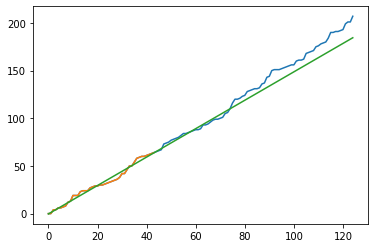

In [967]:
plot_pred(df, 1)

In [968]:
pred_needed, pred, _, _, _, _, till_over = prediction(df, 1)
print(pred_needed)

[178.48273432 179.97286822 181.46300211 182.95313601 184.44326991
 185.93340381 187.4235377  188.9136716  190.4038055  191.89393939]


In [969]:
df.columns

Index(['level_0', 'index', 'match_id', 'batting_team', 'bowling_team', 'over',
       'total_runs', 'wickets', 'runs_past', 'wickets_past', 'Total',
       'run_rate_pred'],
      dtype='object')

In [970]:
df.drop(labels=['level_0', 'index'], axis=1, inplace=True)

In [971]:
encoded_df = pd.get_dummies(data=df, columns=['batting_team', 'bowling_team'])
encoded_df

,match_id,over,total_runs,wickets,runs_past,wickets_past,Total,run_rate_pred,batting_team_Chennai Super Kings,batting_team_Deccan Chargers,...,bowling_team_Gujarat Lions,bowling_team_Kings XI Punjab,bowling_team_Kochi Tuskers Kerala,bowling_team_Kolkata Knight Riders,bowling_team_Mumbai Indians,bowling_team_Pune Warriors,bowling_team_Rajasthan Royals,bowling_team_Rising Pune Supergiants,bowling_team_Royal Challengers Bangalore,bowling_team_Sunrisers Hyderabad
0,1,1.1,0,0,0,0,207.0,178.482734,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,1.2,0,0,0,0,207.0,178.482734,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,1.3,4,0,4,0,207.0,178.482734,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1.4,4,0,4,0,207.0,178.482734,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1.5,6,0,6,0,207.0,178.482734,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36809,636,20.2,194,7,46,3,208.0,190.507611,0,0,...,0,0,0,0,0,0,0,0,1,0
36810,636,20.3,200,7,52,2,208.0,190.507611,0,0,...,0,0,0,0,0,0,0,0,1,0
36811,636,20.4,201,7,49,2,208.0,190.507611,0,0,...,0,0,0,0,0,0,0,0,1,0
36812,636,20.5,202,7,49,2,208.0,190.507611,0,0,...,0,0,0,0,0,0,0,0,1,0


In [972]:
X_train = encoded_df.drop(labels=['Total'], axis=1)[encoded_df['match_id']<500]
X_test = encoded_df.drop(labels=['Total'], axis=1)[encoded_df['match_id']>=500]

y_train = encoded_df[encoded_df['match_id']<500]['Total'].values
y_test = encoded_df[encoded_df['match_id']>=500]['Total'].values

X_train.drop(labels='match_id', axis=True, inplace=True)
X_test.drop(labels='match_id', axis=True, inplace=True)

print("Training set: {} and Test set: {}".format(X_train.shape, X_test.shape))

Training set: (29011, 32) and Test set: (7803, 32)


In [973]:
X_train

,over,total_runs,wickets,runs_past,wickets_past,run_rate_pred,batting_team_Chennai Super Kings,batting_team_Deccan Chargers,batting_team_Delhi Daredevils,batting_team_Gujarat Lions,...,bowling_team_Gujarat Lions,bowling_team_Kings XI Punjab,bowling_team_Kochi Tuskers Kerala,bowling_team_Kolkata Knight Riders,bowling_team_Mumbai Indians,bowling_team_Pune Warriors,bowling_team_Rajasthan Royals,bowling_team_Rising Pune Supergiants,bowling_team_Royal Challengers Bangalore,bowling_team_Sunrisers Hyderabad
0,1.1,0,0,0,0,178.482734,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.2,0,0,0,0,178.482734,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.3,4,0,4,0,178.482734,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1.4,4,0,4,0,178.482734,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1.5,6,0,6,0,178.482734,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29006,20.2,134,4,22,1,134.760797,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
29007,20.3,136,4,23,1,134.760797,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
29008,20.4,137,4,24,1,134.760797,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
29009,20.5,137,4,23,1,134.760797,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [974]:
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()
linear_regressor.fit(X_train,y_train)

LinearRegression()

In [975]:
# AdaBoost Model using Linear Regression as the base learner
from sklearn.ensemble import AdaBoostRegressor
adb_regressor = AdaBoostRegressor(base_estimator=linear_regressor, n_estimators=100)
adb_regressor.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=LinearRegression(), n_estimators=100)

In [976]:
# Random Forest Regression Model
from sklearn.ensemble import RandomForestRegressor
random_regressor = RandomForestRegressor()
random_regressor.fit(X_train,y_train)

RandomForestRegressor()

In [977]:
# Decision Tree Regression Model
from sklearn.tree import DecisionTreeRegressor
decision_regressor = DecisionTreeRegressor()
decision_regressor.fit(X_train,y_train)

DecisionTreeRegressor()

In [978]:
y_pred_train = linear_regressor.predict(X_train)
y_pred_lr = linear_regressor.predict(X_test)
"""
Mean Absolute Error (MAE): 14.609665495978435
Mean Squared Error (MSE): 373.0459384941802
Root Mean Squared Error (RMSE): 19.314397181744507
---- Linear Regression - Model Evaluation ----
Mean Absolute Error (MAE): 20.127624127495757
Mean Squared Error (MSE): 699.3285609053821
Root Mean Squared Error (RMSE): 26.444821060188367
"""

# y_pred_train = adb_regressor.predict(X_train)
# y_pred_lr = adb_regressor.predict(X_test)
"""
Mean Absolute Error (MAE): 15.07120470824387
Mean Squared Error (MSE): 381.8571595563591
Root Mean Squared Error (RMSE): 19.541165767588154
---- Linear Regression - Model Evaluation ----
Mean Absolute Error (MAE): 20.586149636676634
Mean Squared Error (MSE): 707.3919353096983
Root Mean Squared Error (RMSE): 26.596840701664142
"""

# y_pred_train = random_regressor.predict(X_train)
# y_pred_lr = random_regressor.predict(X_test)
"""
Mean Absolute Error (MAE): 0.11669125504119134
Mean Squared Error (MSE): 0.2293455758160698
Root Mean Squared Error (RMSE): 0.4789003819335184
---- Linear Regression - Model Evaluation ----
Mean Absolute Error (MAE): 24.963144944252207
Mean Squared Error (MSE): 1101.0142778931179
Root Mean Squared Error (RMSE): 33.18153519494115
"""

# y_pred_train = decision_regressor.predict(X_train)
# y_pred_lr = decision_regressor.predict(X_test)
"""
Mean Absolute Error (MAE): 0.0
Mean Squared Error (MSE): 0.0
Root Mean Squared Error (RMSE): 0.0
---- Linear Regression - Model Evaluation ----
Mean Absolute Error (MAE): 28.63257721389209
Mean Squared Error (MSE): 1377.0326797385621
Root Mean Squared Error (RMSE): 37.108390961325206
"""

'\nMean Absolute Error (MAE): 0.0\nMean Squared Error (MSE): 0.0\nRoot Mean Squared Error (RMSE): 0.0\n---- Linear Regression - Model Evaluation ----\nMean Absolute Error (MAE): 28.63257721389209\nMean Squared Error (MSE): 1377.0326797385621\nRoot Mean Squared Error (RMSE): 37.108390961325206\n'

In [979]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, accuracy_score
print("Mean Absolute Error (MAE): {}".format(mae(y_train, y_pred_train)))
print("Mean Squared Error (MSE): {}".format(mse(y_train, y_pred_train)))
print("Root Mean Squared Error (RMSE): {}".format(np.sqrt(mse(y_train, y_pred_train))))
print("---- Linear Regression - Model Evaluation ----")
print("Mean Absolute Error (MAE): {}".format(mae(y_test, y_pred_lr)))
print("Mean Squared Error (MSE): {}".format(mse(y_test, y_pred_lr)))
print("Root Mean Squared Error (RMSE): {}".format(np.sqrt(mse(y_test, y_pred_lr))))

Mean Absolute Error (MAE): 14.61265617461381
Mean Squared Error (MSE): 372.1838462718168
Root Mean Squared Error (RMSE): 19.292066925858848
---- Linear Regression - Model Evaluation ----
Mean Absolute Error (MAE): 20.133775228555766
Mean Squared Error (MSE): 696.5532947908079
Root Mean Squared Error (RMSE): 26.392296125778973


In [980]:
def predict_score(batting_team, bowling_team, over, total_runs, wickets, runs_past, wickets_past, run_rate_pred):
  """Predicts score given parameters and model

  Args:
      batting_team (string): Batting Team
      bowling_team (string): Bowling Team
      over (int): Overs till now
      total_runs (int): Total runs till now
      wickets (int): Wickets till now
      runs_past (int): total runs past 4 overs
      wickets_past (int): total wickets past 4 overs
      run_rate_pred (int): prediction of final score using run rate
  """
    
  temp_array = list()

  """
  'Chennai Super Kings' 'Deccan Chargers' 'Delhi Daredevils'
  'Gujarat Lions' 'Kings XI Punjab' 'Kochi Tuskers Kerala'
  'Kolkata Knight Riders' 'Mumbai Indians' 'Pune Warriors'
  'Rajasthan Royals' 'Rising Pune Supergiants'
  'Royal Challengers Bangalore' 'Sunrisers Hyderabad'
  """
  # Batting Team
  if batting_team == 'Chennai Super Kings':
    temp_array = temp_array + [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  elif batting_team == 'Deccan Chargers':
    temp_array = temp_array + [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  elif batting_team == 'Delhi Daredevils':
    temp_array = temp_array + [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  elif batting_team == 'Gujarat Lions':
    temp_array = temp_array + [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  elif batting_team == 'Kings XI Punjab':
    temp_array = temp_array + [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
  elif batting_team == 'Kochi Tuskers Kerala':
    temp_array = temp_array + [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
  elif batting_team == 'Kolkata Knight Riders':
    temp_array = temp_array + [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
  elif batting_team == 'Mumbai Indians':
    temp_array = temp_array + [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  elif batting_team == 'Pune Warriors':
    temp_array = temp_array + [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
  elif batting_team == 'Rajasthan Royals':
    temp_array = temp_array + [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
  elif batting_team == 'Rising Pune Supergiants':
    temp_array = temp_array + [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
  elif batting_team == 'Royal Challengers Bangalore':
    temp_array = temp_array + [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
  elif batting_team == 'Sunrisers Hyderabad':
    temp_array = temp_array + [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

  # Bowling Team
  if bowling_team == 'Chennai Super Kings':
    temp_array = temp_array + [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  elif bowling_team == 'Deccan Chargers':
    temp_array = temp_array + [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  elif bowling_team == 'Delhi Daredevils':
    temp_array = temp_array + [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  elif bowling_team == 'Gujarat Lions':
    temp_array = temp_array + [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  elif bowling_team == 'Kings XI Punjab':
    temp_array = temp_array + [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
  elif bowling_team == 'Kochi Tuskers Kerala':
    temp_array = temp_array + [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
  elif bowling_team == 'Kolkata Knight Riders':
    temp_array = temp_array + [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
  elif bowling_team == 'Mumbai Indians':
    temp_array = temp_array + [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  elif bowling_team == 'Pune Warriors':
    temp_array = temp_array + [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
  elif bowling_team == 'Rajasthan Royals':
    temp_array = temp_array + [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
  elif bowling_team == 'Rising Pune Supergiants':
    temp_array = temp_array + [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
  elif bowling_team == 'Royal Challengers Bangalore':
    temp_array = temp_array + [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
  elif bowling_team == 'Sunrisers Hyderabad':
    temp_array = temp_array + [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

  # Overs, Runs, Wickets, Runs_in_prev_7
  temp_array = [over, total_runs, wickets, runs_past, wickets_past, run_rate_pred] + temp_array

  # Converting into numpy array
  temp_array = np.array([temp_array])

  # Prediction
  return int(linear_regressor.predict(temp_array)[0])

In [981]:
def randomly_sample_and_show_from_train(df:pd.DataFrame, match_id:int=-1, print_=True):
    import random
    matches = df['match_id'].unique()
    match = match_id if match_id!=-1 else random.choice(matches)
    match_info = df.loc[df['match_id'] == match].reset_index()
    value = match_info['Total'][0]

    consideringTillBall = 42

    val = predict_score(match_info['batting_team'][0], match_info['bowling_team'][0], over=match_info['over'][consideringTillBall], total_runs=match_info['total_runs'][consideringTillBall], wickets=match_info['wickets'][consideringTillBall], runs_past=match_info['runs_past'][consideringTillBall], wickets_past=match_info['wickets_past'][consideringTillBall], run_rate_pred=match_info['run_rate_pred'][consideringTillBall])

    pred_needed, pred, c, c_train, x, x_train, till_over = prediction(df, match)

    if print_:
        print("Match ID:", match_info['match_id'][0])
        print("Wickets:", match_info['wickets'].iloc[till_over*6])
        print("Actual prediction from extrapolation:", round(pred[-1], 2))
        print("Prediction from Model:", val)
        print("Actual Value:", value)
        plot_pred(df, match_info['match_id'][0])
    return val, round(pred[-1], 2), match_info['wickets'].iloc[till_over*6], value

In [982]:
with open("predictions_train.csv", "w") as f:
    matches = df['match_id'].unique()
    f.write("match_id,prediction\n")
    for match in matches:
        print("Match ID:", match, end=" ")
        pred, extra_pred, wickets, actual = randomly_sample_and_show_from_train(df, match, print_=False)
        if wickets > 4:
            weight = 0.7
            final_pred = extra_pred*weight + pred*(1-weight)
        else:
            weight = 0.2
            final_pred = extra_pred*weight + pred*(1-weight)
        f.write(str(match) + "," + str(np.round(final_pred, 2))+"\n")
        print("Pred_Model:", pred, ", Pred_extrapolation:", extra_pred, ", Final_pred:", np.round(final_pred, 2), ", Actual:", actual)

Match ID: 1 Pred_Model: 183 , Pred_extrapolation: 184.44 , Final_pred: 183.29 , Actual: 207.0
Match ID: 2 Pred_Model: 179 , Pred_extrapolation: 192.1 , Final_pred: 181.62 , Actual: 184.0
Match ID: 7 Pred_Model: 171 , Pred_extrapolation: 184.54 , Final_pred: 173.71 , Actual: 178.0
Match ID: 8 Pred_Model: 130 , Pred_extrapolation: 87.57 , Final_pred: 121.51 , Actual: 148.0
Match ID: 12 Pred_Model: 171 , Pred_extrapolation: 143.71 , Final_pred: 165.54 , Actual: 142.0
Match ID: 15 Pred_Model: 171 , Pred_extrapolation: 168.19 , Final_pred: 170.44 , Actual: 188.0
Match ID: 17 Pred_Model: 182 , Pred_extrapolation: 197.43 , Final_pred: 185.09 , Actual: 161.0
Match ID: 19 Pred_Model: 154 , Pred_extrapolation: 105.69 , Final_pred: 144.34 , Actual: 159.0
Match ID: 20 Pred_Model: 185 , Pred_extrapolation: 158.74 , Final_pred: 179.75 , Actual: 213.0
Match ID: 21 Pred_Model: 161 , Pred_extrapolation: 127.47 , Final_pred: 154.29 , Actual: 191.0
Match ID: 24 Pred_Model: 159 , Pred_extrapolation: 154.0

TypeError: Cannot index by location index with a non-integer key

[[  7.5         45.           1.          25.           0.
  118.41430585   0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           1.           0.           0.
    0.           0.           0.           0.           0.
    0.           1.           0.           0.           0.
    0.           0.        ]]
Match ID: 562
Wickets: 1
Actual prediction from extrapolation: 122.34
Prediction from Model: 157
Actual Value: 235.0


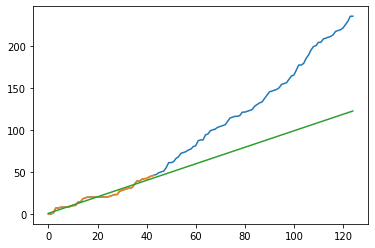

In [ ]:
randomly_sample_and_show_from_train(df, 562)

In [ ]:
def transform_data(df:pd.DataFrame):
    df = df.drop(labels=['batsman', 'non_striker', 'bowler', 'wide_runs', 'bye_runs', 'legbye_runs',
       'noball_runs', 'penalty_runs', 'batsman_runs', 'extra_runs', 'player_dismissed', 'fielder'], axis=1)
    df.rename(columns={'dismissal_kind':'wickets'}, inplace=True)
    matches = df['match_id'].unique()
    df = fix_wicket_column(df)
    df = merge_over_and_ball_columns(df)
    df = add_runs_wickets_cumulative_column(df, 4, matches)
    df.drop(labels=['level_0', 'index'], axis=1, inplace=True)
   #  encoded_df = pd.get_dummies(data=df, columns=['batting_team', 'bowling_team'])
    # Total column contains the total runs of that match that's provided in the data
    X = df.drop(labels=['Total'], axis=1)
    y = encoded_df['Total'].values
    train_data_or_not = True if X.shape[0] > 100 else False
    return X

In [ ]:
df_test = pd.read_csv("./IPL_test.csv")
df_transformed = transform_data(df_test)

In [ ]:
df_transformed

,match_id,batting_team,bowling_team,over,total_runs,wickets,runs_past,wickets_past,run_rate_pred
0,124,Deccan Chargers,Royal Challengers Bangalore,1.1,0,0,0,0,179.339668
1,124,Deccan Chargers,Royal Challengers Bangalore,1.2,4,0,4,0,179.339668
2,124,Deccan Chargers,Royal Challengers Bangalore,1.3,8,0,8,0,179.339668
3,124,Deccan Chargers,Royal Challengers Bangalore,1.4,12,0,12,0,179.339668
4,124,Deccan Chargers,Royal Challengers Bangalore,1.5,12,0,12,0,179.339668
...,...,...,...,...,...,...,...,...,...
6142,304,Royal Challengers Bangalore,Chennai Super Kings,8.3,53,1,22,0,134.087889
6143,304,Royal Challengers Bangalore,Chennai Super Kings,8.4,54,1,23,0,134.087889
6144,304,Royal Challengers Bangalore,Chennai Super Kings,8.5,56,1,21,0,134.087889
6145,304,Royal Challengers Bangalore,Chennai Super Kings,8.6,60,1,25,0,134.087889


In [ ]:
def randomly_sample_and_show_from_test(df_transformed:pd.DataFrame, match_id:int=-1, print_=True):
    matches = df_transformed['match_id'].unique()
    match = match_id if match_id != -1 else random.choice(matches)
    match_info = df_transformed.loc[df_transformed['match_id'] == match].reset_index()

    consideringTillBall = match_info.shape[0]-1

    val = predict_score(match_info['batting_team'][0], match_info['bowling_team'][0], over=match_info['over'][consideringTillBall], total_runs=match_info['total_runs'][consideringTillBall], wickets=match_info['wickets'][consideringTillBall], runs_past=match_info['runs_past'][consideringTillBall], wickets_past=match_info['wickets_past'][consideringTillBall], run_rate_pred=match_info['run_rate_pred'][consideringTillBall])

    pred_needed, pred, c, c_train, x, x_train, till_over = prediction(df_transformed, match)

    if print_:
        print("Match ID:", match_info['match_id'][0])
        print("Wickets:", match_info['wickets'].iloc[-1])
        print("Actual prediction from extrapolation:", round(pred_needed[0], 2))
        print("Prediction from Model:", val)
        plot_pred(df_transformed, match_info['match_id'][0])
    return val, round(pred_needed[0], 2), match_info['wickets'].iloc[-1]

Match ID: 136
Wickets: 4
Actual prediction from extrapolation: 109.1
Prediction from Model: 139


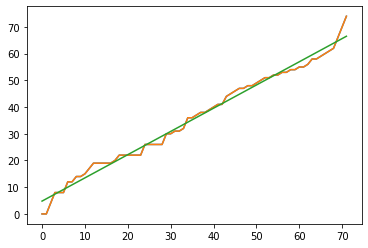

In [ ]:
pred, extra_pred, wickets = randomly_sample_and_show_from_test(df_transformed)

In [ ]:
df_transformed[df_transformed['match_id']==300]

,match_id,batting_team,bowling_team,over,total_runs,wickets,runs_past,wickets_past,run_rate_pred
5856,300,Deccan Chargers,Kings XI Punjab,1.1,1,0,0,0,179.205859
5857,300,Deccan Chargers,Kings XI Punjab,1.2,1,0,0,0,179.205859
5858,300,Deccan Chargers,Kings XI Punjab,1.3,1,0,0,0,179.205859
5859,300,Deccan Chargers,Kings XI Punjab,1.4,3,0,2,0,179.205859
5860,300,Deccan Chargers,Kings XI Punjab,1.5,4,0,3,0,179.205859
...,...,...,...,...,...,...,...,...,...
5917,300,Deccan Chargers,Kings XI Punjab,10.5,85,0,24,0,179.205859
5918,300,Deccan Chargers,Kings XI Punjab,10.6,85,0,24,0,179.205859
5919,300,Deccan Chargers,Kings XI Punjab,11.1,89,0,24,0,179.205859
5920,300,Deccan Chargers,Kings XI Punjab,11.2,90,0,24,0,179.205859


In [ ]:
with open("predictions.csv", "w") as f:
    matches = df_transformed['match_id'].unique()
    f.write("match_id,prediction\n")
    for match in matches:
        print("Match ID:", match, end=" ")
        pred, extra_pred, wickets = randomly_sample_and_show_from_test(df_transformed, match, print_=False)
        if wickets > 4:
            weight = 0.7
            final_pred = extra_pred*weight + pred*(1-weight)
        else:
            weight = 0.2
            final_pred = extra_pred*weight + pred*(1-weight)
        f.write(str(match) + "," + str(np.round(final_pred, 2))+"\n")
        print("Pred_Model:", pred, "Pred_extrapolation", extra_pred, "Final_pred", final_pred)

Match ID: 124 Pred_Model: 178 Pred_extrapolation 179.34 Final_pred 178.268
Match ID: 592 Pred_Model: 171 Pred_extrapolation 143.0 Final_pred 165.4
Match ID: 630 Pred_Model: 170 Pred_extrapolation 153.66 Final_pred 166.732
Match ID: 188 Pred_Model: 167 Pred_extrapolation 151.28 Final_pred 163.856
Match ID: 287 Pred_Model: 182 Pred_extrapolation 165.73 Final_pred 178.74599999999998
Match ID: 269 Pred_Model: 133 Pred_extrapolation 101.36 Final_pred 126.67200000000001
Match ID: 174 Pred_Model: 153 Pred_extrapolation 120.84 Final_pred 146.568
Match ID: 107 Pred_Model: 120 Pred_extrapolation 82.38 Final_pred 112.476
Match ID: 465 Pred_Model: 153 Pred_extrapolation 115.18 Final_pred 145.436
Match ID: 388 Pred_Model: 115 Pred_extrapolation 111.53 Final_pred 114.306
Match ID: 607 Pred_Model: 149 Pred_extrapolation 121.59 Final_pred 143.518
Match ID: 77 Pred_Model: 164 Pred_extrapolation 145.98 Final_pred 160.39600000000002
Match ID: 22 Pred_Model: 172 Pred_extrapolation 142.41 Final_pred 166.08

Match ID: 9
Wickets: 2
Actual prediction from extrapolation: 169.97
Prediction from Model: 175


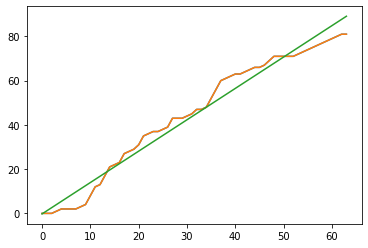

(175, 169.97, 2)

In [ ]:
randomly_sample_and_show_from_test(df_transformed, 9)

In [ ]:
match_info = df_transformed[df_transformed['match_id']==9].reset_index()
consideringTillBall = match_info.shape[0]-1
consideringTillBall

63